## General Observations

Datasets that are too imbalanced: 
- Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv 
- Friday-23-02-2018_TrafficForML_CICFlowMeter.csv 

Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv
- not very good label seperation, should check every csv to see which one has best seperation. 
- only got destination port

Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
- Seperation on Fwd PSH Flag 
- Pkt legnth is always left skewed
- only got destination port 

Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv
- got both dest and src port, with dest and src IP, can use this to make a network? 
- looks like a lot of features have the exact same label wise trend tho

Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv
- only got dest port 
- 3 labels should merge the 2 types of ddos attacks? 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import networkx as nx

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-adjust width
pd.set_option('display.colheader_justify', 'left')  # Align headers properly
pd.set_option('display.max_colwidth', None)  # Don't truncate column values


/Users/emmalim/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Folder containing CSV files
folder_path = "/Users/emmalim/Desktop/CIC-IDS2018/Processed Traffic Data for ML Algorithms"
ddos2018_csv = "/Users/emmalim/Desktop/CIC-IDS2018/Processed Traffic Data for ML Algorithms/Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv"
ddos2017_csv = "/Users/emmalim/Desktop/TrafficLabelling /Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"

# DDoS attacks-LOIC-HTTP 

In [3]:
ddos2018_df = pd.read_csv(ddos2018_csv)
ddos2017_df = pd.read_csv(ddos2017_csv)
print(ddos2017_df.info())
print(ddos2018_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 85 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Flow ID                       225745 non-null  object 
 1    Source IP                    225745 non-null  object 
 2    Source Port                  225745 non-null  int64  
 3    Destination IP               225745 non-null  object 
 4    Destination Port             225745 non-null  int64  
 5    Protocol                     225745 non-null  int64  
 6    Timestamp                    225745 non-null  object 
 7    Flow Duration                225745 non-null  int64  
 8    Total Fwd Packets            225745 non-null  int64  
 9    Total Backward Packets       225745 non-null  int64  
 10  Total Length of Fwd Packets   225745 non-null  int64  
 11   Total Length of Bwd Packets  225745 non-null  int64  
 12   Fwd Packet Length Max        225745 non-nul

## Data cleaning

In [4]:
ddos2017_df.columns = ddos2017_df.columns.str.strip()
ddos2018_df.columns = ddos2018_df.columns.str.strip()
ddos2017_df = ddos2017_df.drop(columns=["Fwd Header Length.1"], errors="ignore")

column_mapping = {
    "Src IP": "Source IP",
    "Src Port": "Source Port",
    "Dst IP": "Destination IP",
    "Dst Port": "Destination Port",
    "Tot Fwd Pkts": "Total Fwd Packets",
    "Tot Bwd Pkts": "Total Backward Packets",
    "TotLen Fwd Pkts": "Total Length of Fwd Packets",
    "TotLen Bwd Pkts": "Total Length of Bwd Packets",
    "Fwd Pkt Len Max": "Fwd Packet Length Max",
    "Fwd Pkt Len Min": "Fwd Packet Length Min",
    "Fwd Pkt Len Mean": "Fwd Packet Length Mean",
    "Fwd Pkt Len Std": "Fwd Packet Length Std",
    "Bwd Pkt Len Max": "Bwd Packet Length Max",
    "Bwd Pkt Len Min": "Bwd Packet Length Min",
    "Bwd Pkt Len Mean": "Bwd Packet Length Mean",
    "Bwd Pkt Len Std": "Bwd Packet Length Std",
    "Flow Byts/s": "Flow Bytes/s",
    "Flow Pkts/s": "Flow Packets/s",
    "Fwd IAT Tot": "Fwd IAT Total",
    "Bwd IAT Tot": "Bwd IAT Total",
    "Fwd Header Len": "Fwd Header Length",
    "Bwd Header Len": "Bwd Header Length",
    "Fwd Pkts/s": "Fwd Packets/s",
    "Bwd Pkts/s": "Bwd Packets/s",
    "Pkt Len Min": "Min Packet Length",
    "Pkt Len Max": "Max Packet Length",
    "Pkt Len Mean": "Packet Length Mean",
    "Pkt Len Std": "Packet Length Std",
    "Pkt Len Var": "Packet Length Variance",
    "FIN Flag Cnt": "FIN Flag Count",
    "SYN Flag Cnt": "SYN Flag Count",
    "RST Flag Cnt": "RST Flag Count",
    "PSH Flag Cnt": "PSH Flag Count",
    "ACK Flag Cnt": "ACK Flag Count",
    "URG Flag Cnt": "URG Flag Count",
    "ECE Flag Cnt": "ECE Flag Count",
    "CWE Flag Count": "CWE Flag Count",
    "Pkt Size Avg": "Average Packet Size",
    "Fwd Seg Size Avg": "Avg Fwd Segment Size",
    "Bwd Seg Size Avg": "Avg Bwd Segment Size",
    "Init Fwd Win Byts": "Init_Win_bytes_forward",
    "Init Bwd Win Byts": "Init_Win_bytes_backward",
    "Fwd Act Data Pkts": "act_data_pkt_fwd",
    "Fwd Seg Size Min": "min_seg_size_forward",
    "Fwd Byts/b Avg": "Fwd Avg Bytes/Bulk",
    "Bwd Blk Rate Avg": "Bwd Avg Bulk Rate",
    "Subflow Bwd Byts": "Subflow Bwd Bytes",
    "Subflow Fwd Pkts": "Subflow Fwd Packets",
    "Subflow Fwd Byts": "Subflow Fwd Bytes",
    "Fwd Blk Rate Avg": "Fwd Avg Bulk Rate",
    "Subflow Bwd Pkts": "Subflow Bwd Packets",
    "Fwd Pkts/b Avg": "Fwd Avg Packets/Bulk",
    "Bwd Pkts/b Avg": "Bwd Avg Packets/Bulk",
    "Bwd Byts/b Avg": "Bwd Avg Bytes/Bulk"
}
ddos2018_df.rename(columns=column_mapping, inplace=True)


In [6]:
# Extract the hour and minute as separate columns (vectorized)
ddos2018_df['Timestamp'] = pd.to_datetime(ddos2018_df['Timestamp'])
ddos2018_df['hour'] = ddos2018_df['Timestamp'].dt.hour
ddos2018_df['minute'] = ddos2018_df['Timestamp'].dt.minute

# Define the time window for comparison
start_hour, start_minute = 10, 0
end_hour, end_minute = 11, 30

# Filter rows where Timestamp is between 10:00 and 11:30
filtered_df = ddos2018_df[(ddos2018_df['hour'] > start_hour) | 
                          ((ddos2018_df['hour'] == start_hour) & (ddos2018_df['minute'] >= start_minute))]

filtered_ddos2018_df = filtered_df[(filtered_df['hour'] < end_hour) | 
                          ((filtered_df['hour'] == end_hour) & (filtered_df['minute'] <= end_minute))]

/var/folders/kf/13qk055j6hz1vpgtkkpw6pyw0000gn/T/ipykernel_11616/779668574.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ddos2018_df['Timestamp'] = pd.to_datetime(ddos2018_df['Timestamp'])


In [7]:
print(filtered_ddos2018_df['Label'].value_counts())
print(ddos2017_df['Label'].value_counts())

Label
Benign                    1343290
DDoS attacks-LOIC-HTTP     575394
Name: count, dtype: int64
Label
DDoS      128027
BENIGN     97718
Name: count, dtype: int64


In [14]:
filtered_ddos2018_df.columns

Index(['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
  

In [20]:
# Save the cleaned 2017 dataframe
ddos2017_df.to_csv('/Users/emmalim/Desktop/DSA4263/ddos2017_cleaned.csv', index=False)

# Save the cleaned 2018 dataframe
filtered_ddos2018_df.to_csv('/Users/emmalim/Desktop/DSA4263/ddos2018_cleaned.csv', index=False)

NameError: name 'ddos2017_df' is not defined

## Basic Traffic Volume Analysis
- each row is a portion of a flow from source to destination IP. Each row can represent the summary of a certain number of packets.
- all the attack flows happen within a short time period, from the a few Source IPs on the same Destination IP
- For 2018, there isnt a spike in traffic, but for 2017, there is a clear spike in traffic when attack is being carried out. --> the distribution between labels for both datasets are quite different.

In [3]:
ddos2018_df_cleaned = pd.read_csv('/Users/emmalim/Desktop/DSA4263/ddos2018_cleaned.csv')
ddos2017_df_cleaned = pd.read_csv('/Users/emmalim/Desktop/DSA4263/ddos2017_cleaned.csv')

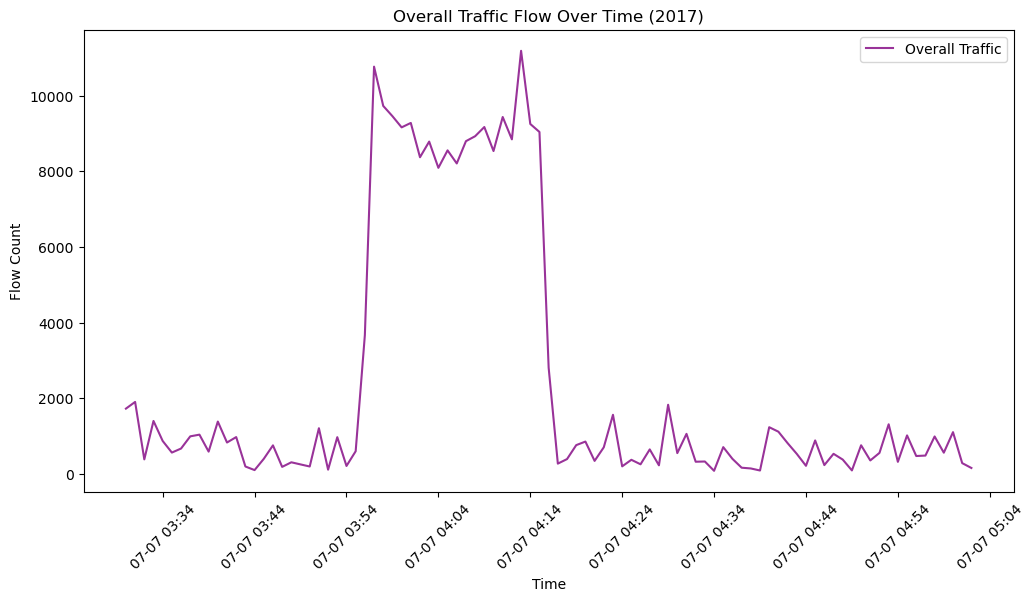

In [94]:
# Copy dataset
analysis_df = ddos2017_df_cleaned.copy()

# Convert Timestamp to datetime
analysis_df['Timestamp'] = pd.to_datetime(analysis_df['Timestamp'])

# Count overall flows per second
analysis_df['Time_Seconds'] = analysis_df['Timestamp'].dt.floor('s')
overall_traffic = analysis_df.groupby('Time_Seconds').size()

# Plot the overall traffic flow
plt.figure(figsize=(12,6))
plt.plot(overall_traffic.index, overall_traffic, label="Overall Traffic", color='purple', alpha=0.8)

# Labels and legend
plt.xlabel("Time")
plt.ylabel("Flow Count")
plt.title("Overall Traffic Flow Over Time (2017)")
plt.legend()

# Improve x-axis time format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # Format: Month-Day Hour:Minute
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))  # Adjust interval as needed
plt.xticks(rotation=45)  # Rotate for better readability

plt.show()


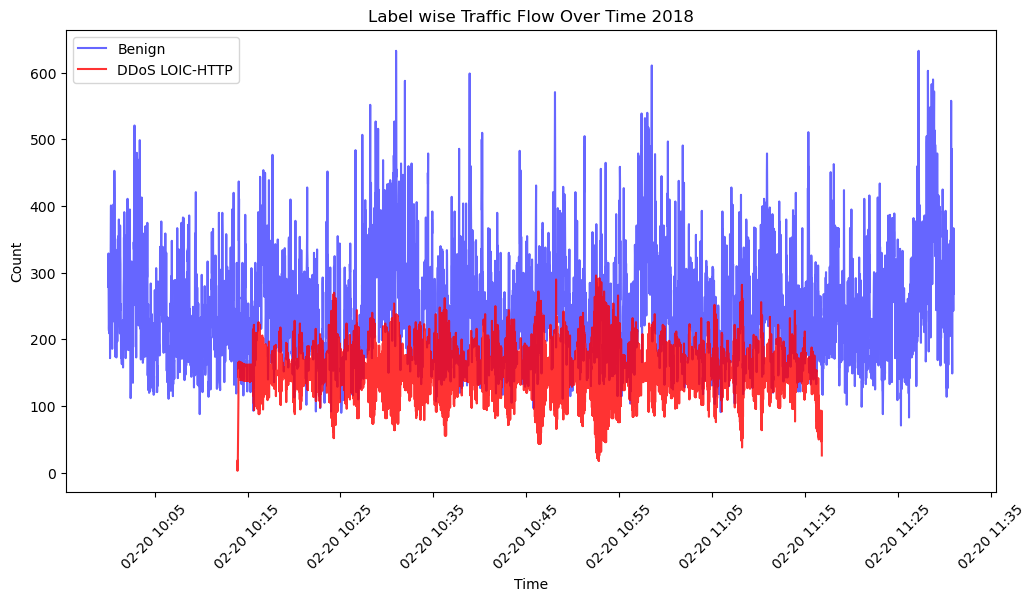

In [93]:
analysis_df = ddos2018_df_cleaned.copy()

# Convert Timestamp to datetime
analysis_df['Timestamp'] = pd.to_datetime(analysis_df['Timestamp'])

# Count flows per second, grouped by attack type
analysis_df['Time_Seconds'] = analysis_df['Timestamp'].dt.floor('s')
attack_traffic = analysis_df[analysis_df['Label'] == 'DDoS attacks-LOIC-HTTP'].groupby('Time_Seconds').size()
benign_traffic = analysis_df[analysis_df['Label'] == 'Benign'].groupby('Time_Seconds').size()

# Plot the flow activity with different colors
plt.figure(figsize=(12,6))
plt.plot(benign_traffic.index, benign_traffic, label="Benign", color='blue', alpha=0.6)
plt.plot(attack_traffic.index, attack_traffic, label="DDoS LOIC-HTTP", color='red', alpha=0.8)

# Labels and legend
plt.xlabel("Time")
plt.ylabel("Count")
plt.title("Label wise Traffic Flow Over Time 2018")
plt.legend()


# Improve x-axis time format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # Format: Month-Day Hour:Minute
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))  # Show labels every 2 hours
plt.xticks(rotation=45)  # Rotate for better readability

plt.show()

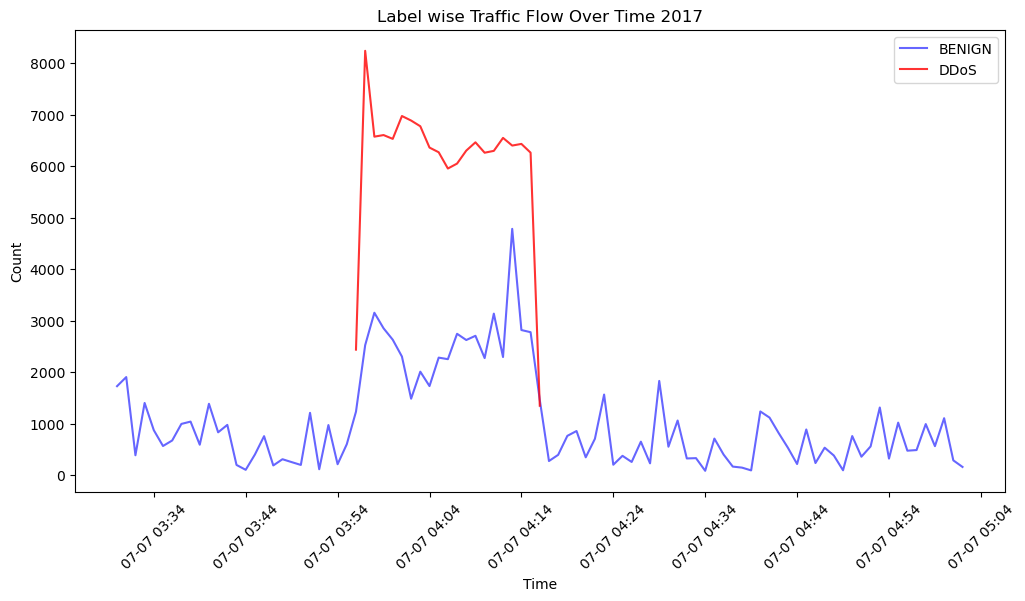

In [90]:
analysis_df_2017 = ddos2017_df_cleaned.copy()

# Convert Timestamp to datetime
analysis_df_2017['Timestamp'] = pd.to_datetime(analysis_df_2017['Timestamp'])

# Count flows per second, grouped by attack type
analysis_df_2017['Time_Seconds'] = analysis_df_2017['Timestamp'].dt.floor('s')
attack_traffic = analysis_df_2017[analysis_df_2017['Label'] == 'DDoS'].groupby('Time_Seconds').size()
benign_traffic = analysis_df_2017[analysis_df_2017['Label'] == 'BENIGN'].groupby('Time_Seconds').size()

# Plot the flow activity with different colors
plt.figure(figsize=(12,6))
plt.plot(benign_traffic.index, benign_traffic, label="BENIGN", color='blue', alpha=0.6)
plt.plot(attack_traffic.index, attack_traffic, label="DDoS", color='red', alpha=0.8)

# Labels and legend
plt.xlabel("Time")
plt.ylabel("Count")
plt.title("Label wise Traffic Flow Over Time 2017")
plt.legend()


# Improve x-axis time format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # Format: Month-Day Hour:Minute
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))  # Show labels every 2 hours
plt.xticks(rotation=45)  # Rotate for better readability

plt.show()

## Analyse expected positive relationships
* Flow duration: DoS/DDoS attacks often prolonged high-volume traffic or very short, intense bursts. 
* DDoS Attacks: In DDoS attacks, the inter-arrival time between packets might be very short (indicating that many packets are being sent in a short period of time), which can cause network congestion. Normal Traffic: For normal traffic, the inter-arrival time is typically more spread out, as packets are often sent with more regular intervals.


- seems like the overall distribution of each dataset are different. If we  use 2017 for training and 2018 for prediction, results are unlikely to be very good.

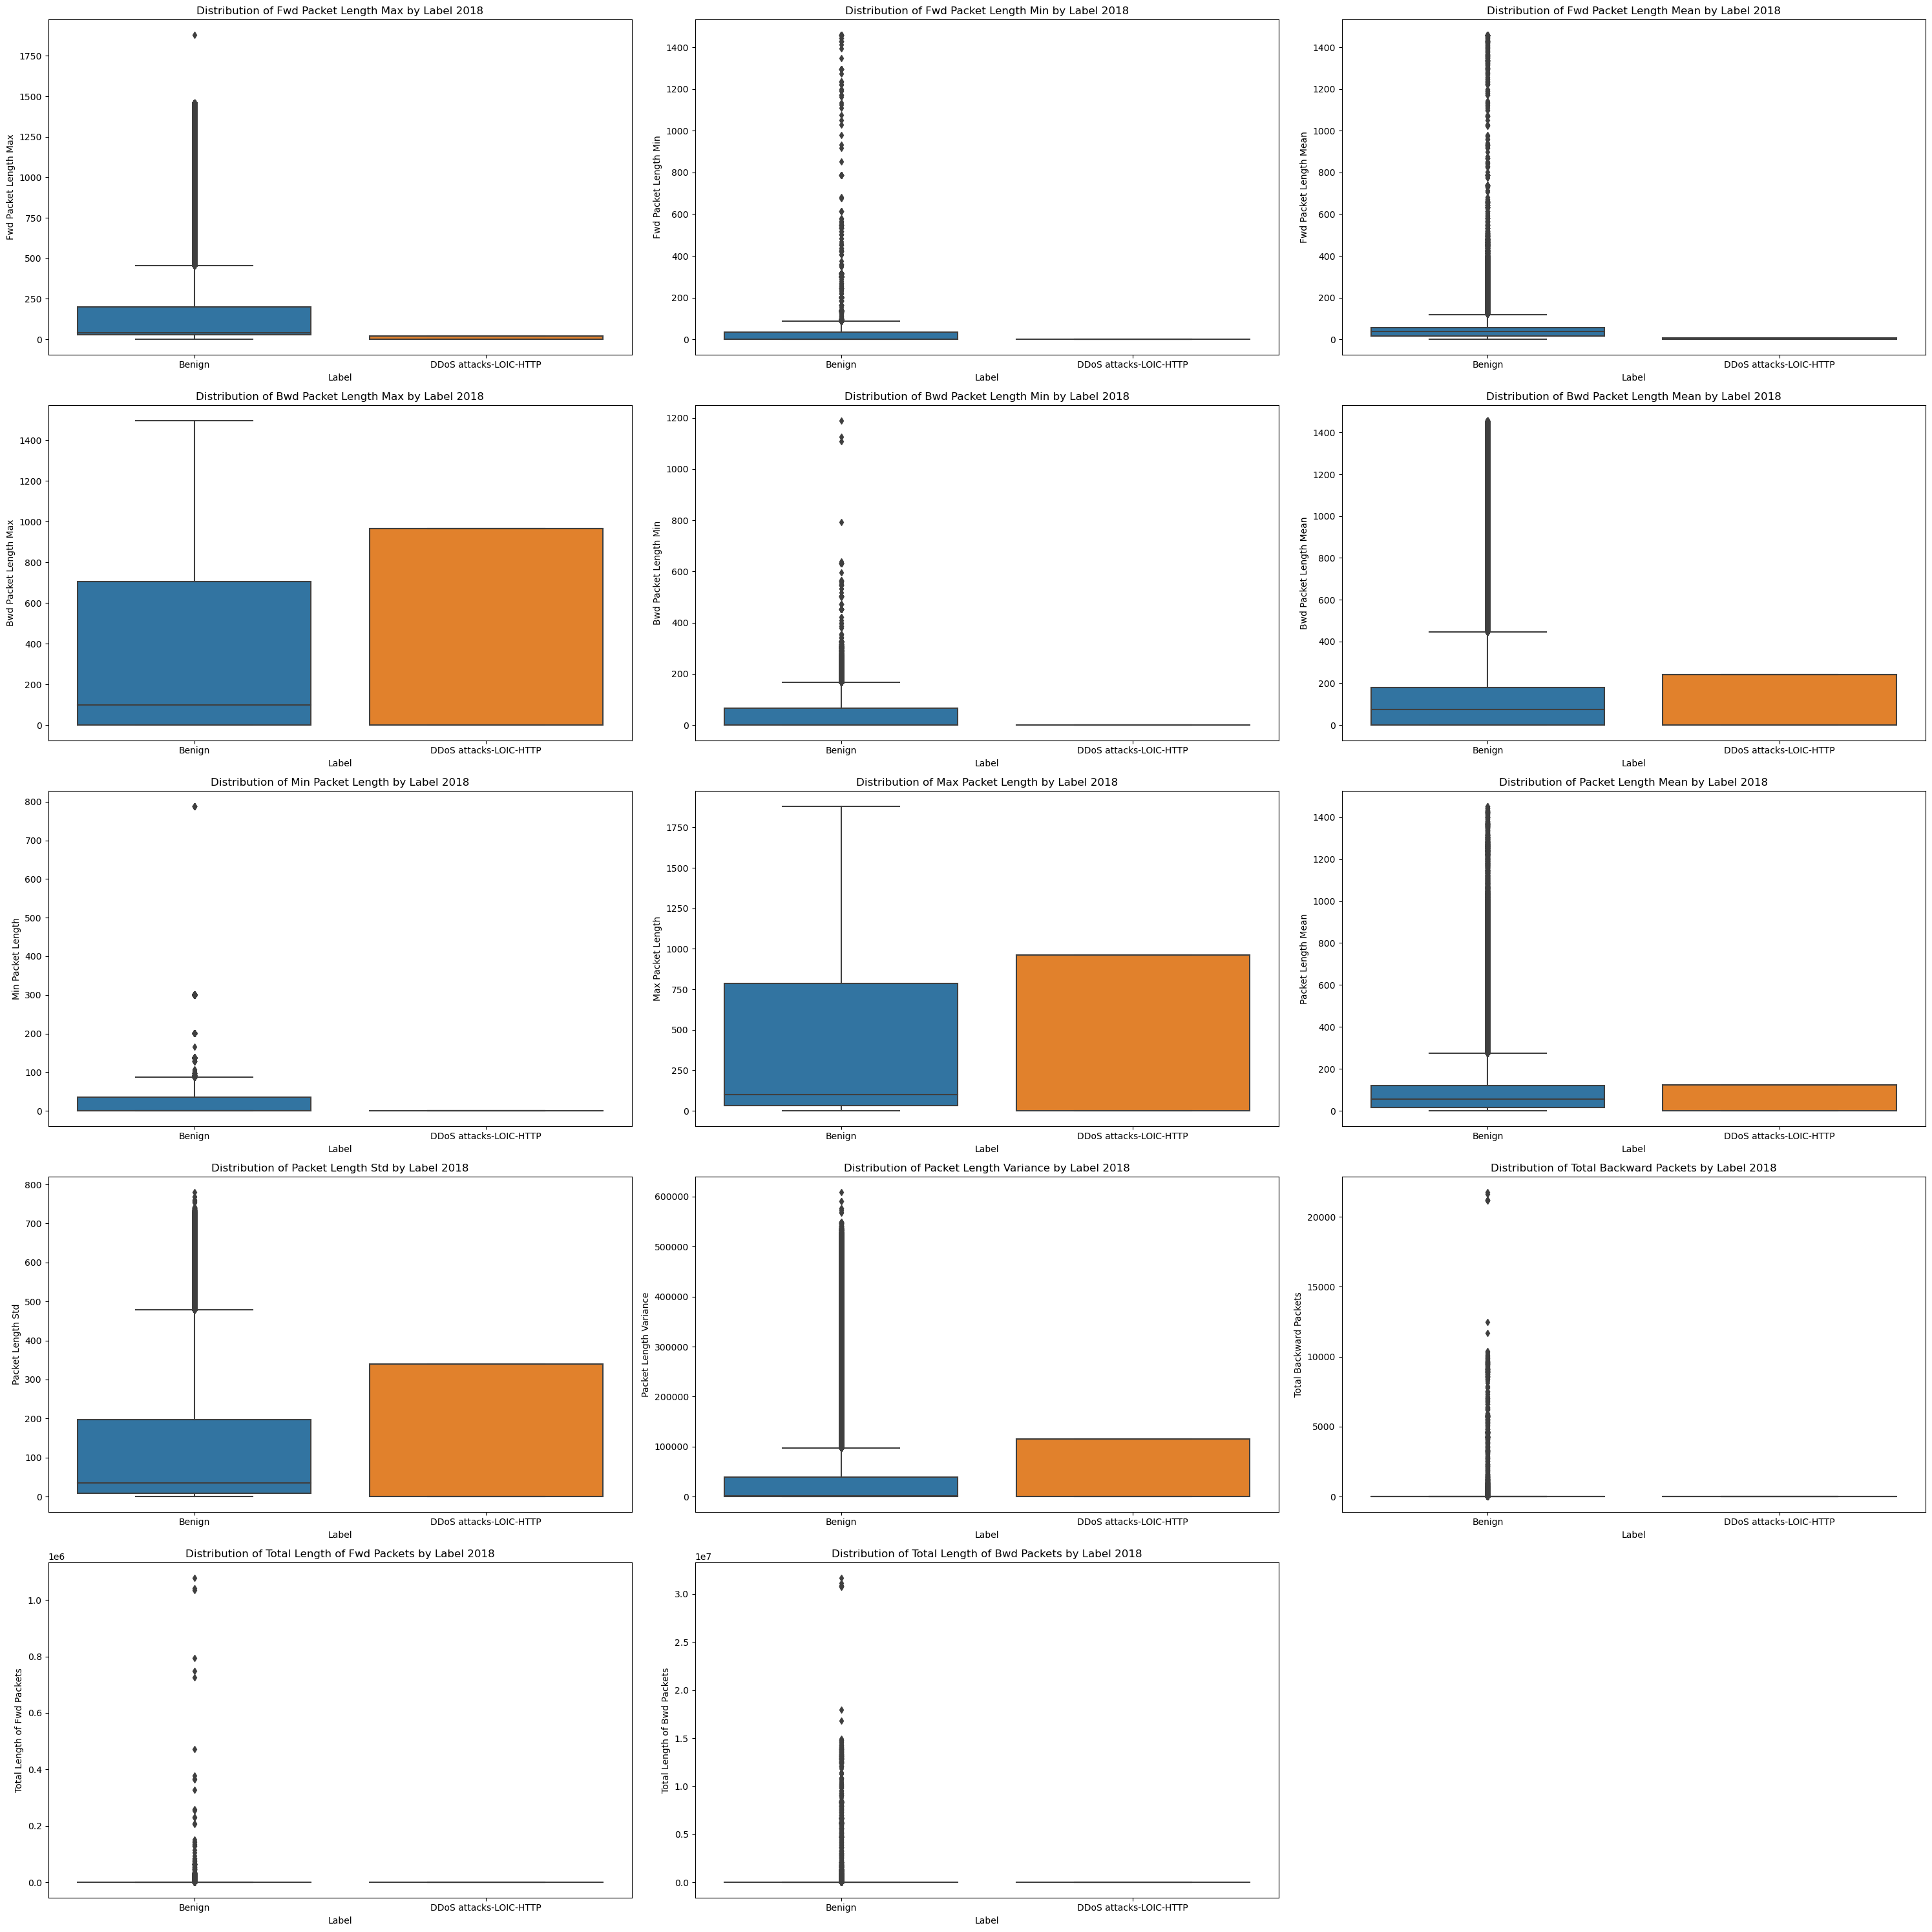

In [111]:
# List of packet size-related features
packet_size_features = [
    'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
    'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
    'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
    'Packet Length Std', 'Packet Length Variance', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets'
]

# Visualizing packet size distributions for both Benign and DDoS traffic
plt.figure(figsize=(30, 30))
for i, feature in enumerate(packet_size_features, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(x='Label', y=feature, data=ddos2018_df_cleaned)
    plt.title(f'Distribution of {feature} by Label 2018')
plt.tight_layout()
plt.show()

## Network Analysis 

- Edge Weight Distribution - if edge weight is count of flow ID between each src and dst ip, can try use average edge weights to identify DoS 
- Degree Centrality - high degree centrality = more edges connected to the node --> might be able to find source nodes that are being attacked. 

In [4]:
ddos2018_df_cleaned.head(10)

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,hour,minute
0,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,2018-02-20 10:00:40,112640715,3,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.026633,5.630000e+07,1.767767e+01,56300000.0,56300000.0,113000000.0,5.630000e+07,17.677670,56300000.0,56300000.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0,0,0,0,0.026633,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0.0,0.0,56300000.0,17.677670,56300000.0,56300000.0,Benign,10,0
1,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,2018-02-20 10:03:29,112640744,3,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.026633,5.630000e+07,7.071068e+00,56300000.0,56300000.0,113000000.0,5.630000e+07,7.071068,56300000.0,56300000.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0,0,0,0,0.026633,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0.0,0.0,56300000.0,7.071068,56300000.0,56300000.0,Benign,10,3
2,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,2018-02-20 10:06:18,112640793,3,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.026633,5.630000e+07,4.454773e+01,56300000.0,56300000.0,113000000.0,5.630000e+07,44.547727,56300000.0,56300000.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0,0,0,0,0.026633,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0.0,0.0,56300000.0,44.547727,56300000.0,56300000.0,Benign,10,6
3,172.31.69.25-221.194.47.233-22-56958-6,221.194.47.233,56958,172.31.69.25,22,6,2018-02-20 10:10:59,5707641,14,11,1123.0,1969.0,648.0,0.0,80.214286,178.523939,976.0,0.0,179.000000,364.186491,541.729937,4.380093,2.378184e+05,3.638962e+05,1602023.0,13.0,5707641.0,4.390493e+05,402745.724100,1602023.0,13.0,5200191.0,5.200191e+05,6.160708e+05,2164553.0,74.0,0,0,0,0,456,360,2.452852,1.927241,0.0,976.0,118.923077,269.478003,72618.39385,0,0,0,1,0,0,0,0,0.0,123.680000,80.214286,179.000000,0,0,0,0,0,0,14,1123,11,1969,29200,230,7,32,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,10,10
4,131.202.242.193-172.31.69.25-8837-80-6,131.202.242.193,8837,172.31.69.25,80,6,2018-02-20 10:11:19,5056542,4,4,281.0,509.0,281.0,0.0,70.250000,140.500000,509.0,0.0,127.250000,254.500000,156.233252,1.582109,7.223631e+05,1.852103e+06,4921945.0,21.0,134597.0,4.486567e+04,38407.018020,84209.0,7469.0,5056519.0,1.685506e+06,2.875051e+06,5005206.0,927.0,0,0,0,0,92,92,0.791054,0.791054,0.0,509.0,87.777778,183.268094,33587.19444,0,0,0,1,0,0,0,0,1.0,98.750000,70.250000,127.250000,0,0,0,0,0,0,4,281,4,509,64240,219,1,20,0.0

### Statistical Analyis of Network (2018)

In [27]:
# Create a directed graph (assuming flow direction matters)
G = nx.DiGraph()
network_df = ddos2018_df_cleaned[['Source IP', 'Destination IP', 'Flow ID', 'Label']]
# Add weighted edges
for _, row in network_df.iterrows():
    src, dst = row["Source IP"], row["Destination IP"]
    
    if G.has_edge(src, dst):
        G[src][dst]['weight'] += 1  # Increase weight if edge exists
    else:
        G.add_edge(src, dst, weight=1, label=row["Label"])  # Add new edge with weight 1
        
        
node_labels = {}
for _, row in network_df.iterrows():
    src, dst, label = row["Source IP"], row["Destination IP"], row["Label"]
    
    # If node is already labeled "Attack", keep it
    if node_labels.get(src) != "DDoS attacks-LOIC-HTTP":
        node_labels[src] = label  # Assign attack or benign label
    if node_labels.get(dst) != "DDoS attacks-LOIC-HTTP":
        node_labels[dst] = label  # Destination might also be relevant

In [28]:
print(G)

DiGraph with 13848 nodes and 206692 edges


In [ ]:
# Compute graph metrics
degree_centrality = nx.degree_centrality(G)  # Unweighted
weighted_degree = {node: sum(data["weight"] for _, data in G[node].items()) for node in G}  # Weighted
pagerank = nx.pagerank(G, weight='weight')
betweenness = nx.betweenness_centrality(G, weight='weight')
k_core = nx.core_number(G)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame({
    "Node": list(G.nodes),
    "Degree Centrality": [degree_centrality[node] for node in G.nodes],
    "Weighted Degree": [weighted_degree.get(node, 0) for node in G.nodes],
    "PageRank": [pagerank[node] for node in G.nodes],
    "Betweenness": [betweenness[node] for node in G.nodes],
    "K-Core Number": [k_core[node] for node in G.nodes]
})

# Add attack/benign labels
metrics_df["Label"] = metrics_df["Node"].map(node_labels)



In [39]:
# Separate attack and benign nodes
attack_metrics = metrics_df[metrics_df["Label"] == "DDoS attacks-LOIC-HTTP"]
benign_metrics = metrics_df[metrics_df["Label"] == "Benign"]

/Users/emmalim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/emmalim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/emmalim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/emmalim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

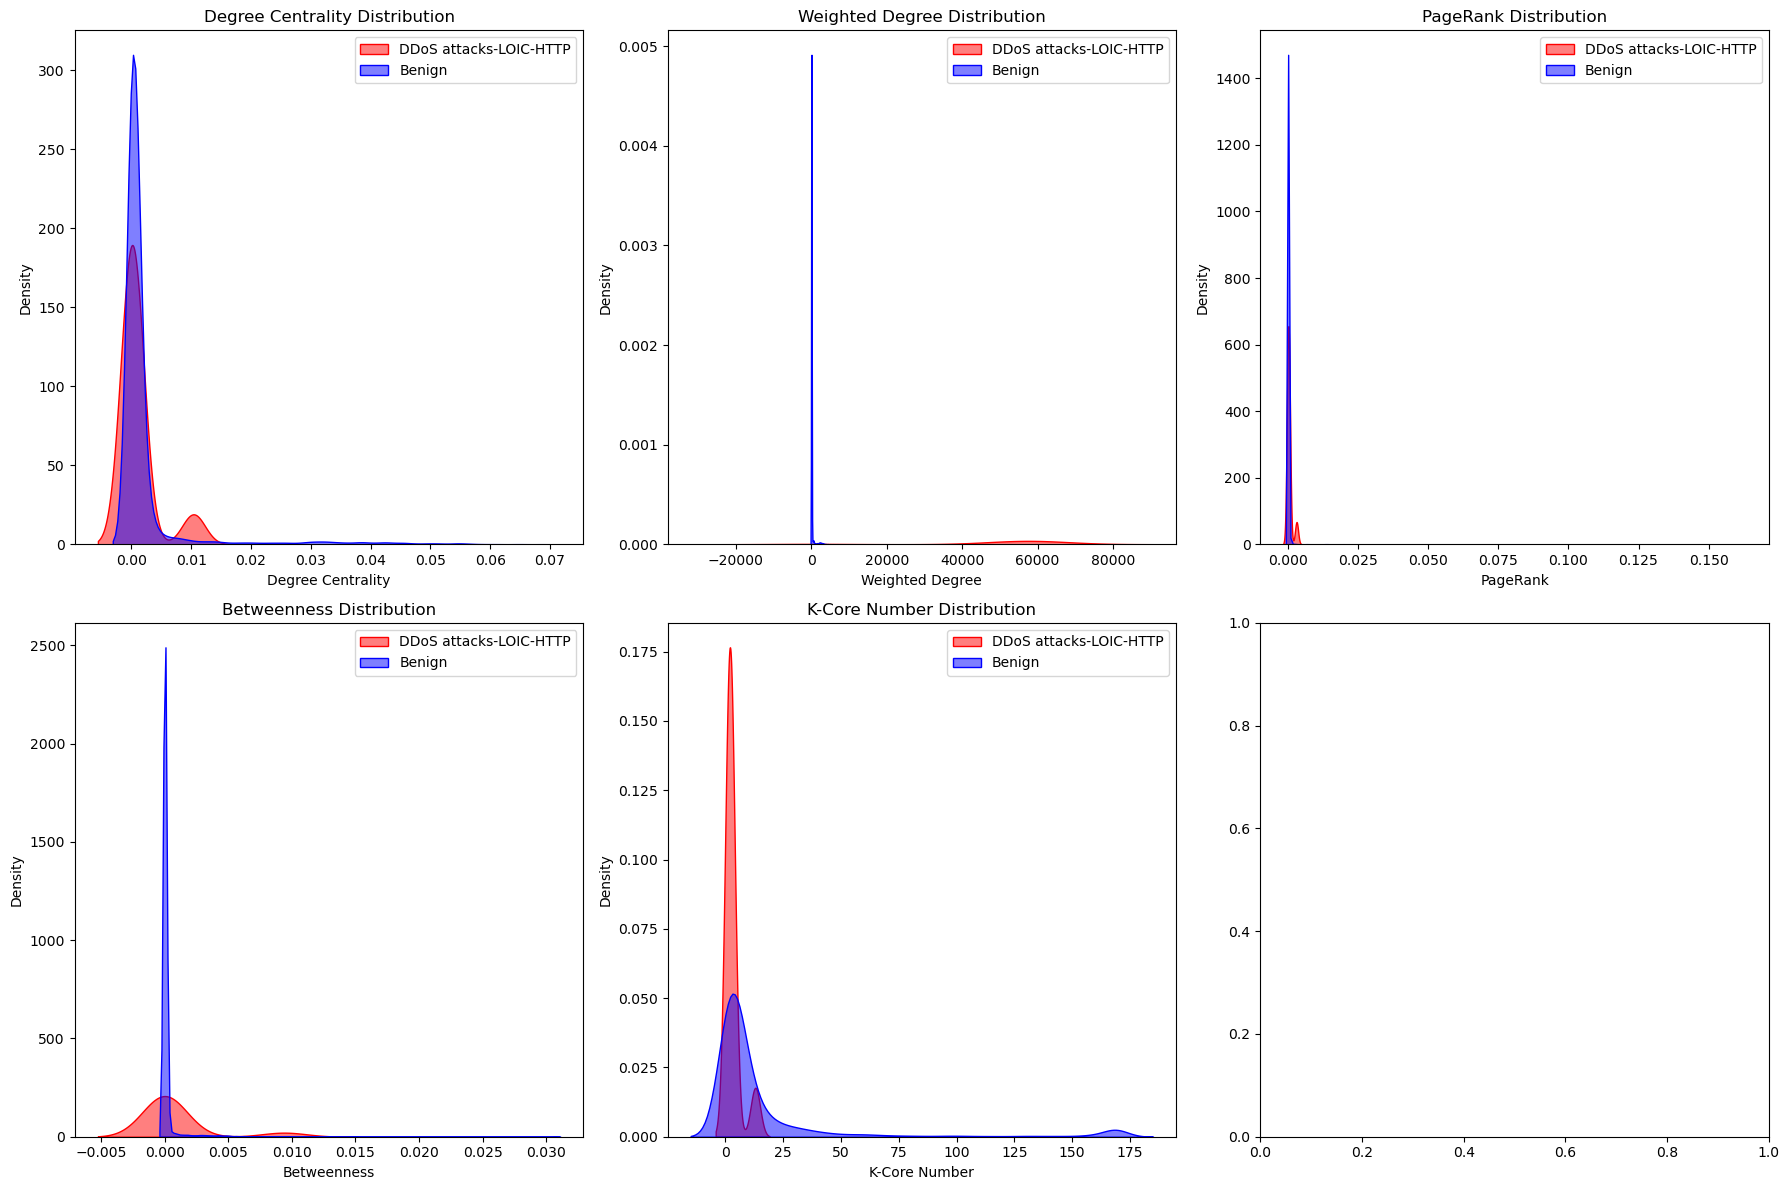

In [40]:
# Plot distributions for different metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

metrics = ["Degree Centrality", "Weighted Degree", "PageRank", "Betweenness", "K-Core Number"]
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    sns.kdeplot(attack_metrics[metric], label="DDoS attacks-LOIC-HTTP", fill=True, color="red", alpha=0.5, ax=ax)
    sns.kdeplot(benign_metrics[metric], label="Benign", fill=True, color="blue", alpha=0.5, ax=ax)
    ax.set_title(f"{metric} Distribution")
    ax.legend()

plt.tight_layout()
plt.show()


In [44]:
from scipy.stats import ks_2samp, mannwhitneyu, ttest_ind

for metric in metrics:
    attack_values = attack_metrics[metric]
    benign_values = benign_metrics[metric]

    if len(attack_values) > 0 and len(benign_values) > 0:
        ks_stat, ks_p = ks_2samp(attack_values, benign_values)
        mw_stat, mw_p = mannwhitneyu(attack_values, benign_values, alternative='two-sided')
        t_stat, tt_p = ttest_ind(attack_values, benign_values)


        print(f"\n{metric}:")
        print(f"  Kolmogorov-Smirnov test: Statistic={ks_stat:.4f}, p-value={ks_p:.4f}")
        print(f"  Mann-Whitney U test: Statistic={mw_stat:.4f}, p-value={mw_p:.4f}")
        print(f"  T-test: Statistic={t_stat:.4f}, p-value={tt_p:.4f}")
    else:
        print(f"\nSkipping {metric}: One of the distributions is empty.")


Degree Centrality:
  Kolmogorov-Smirnov test: Statistic=0.4952, p-value=0.0052
  Mann-Whitney U test: Statistic=52096.0000, p-value=0.0667
  T-test: Statistic=-0.5015, p-value=0.6160

Weighted Degree:
  Kolmogorov-Smirnov test: Statistic=0.9462, p-value=0.0000
  Mann-Whitney U test: Statistic=151462.5000, p-value=0.0000
  T-test: Statistic=260.5858, p-value=0.0000

PageRank:
  Kolmogorov-Smirnov test: Statistic=0.9437, p-value=0.0000
  Mann-Whitney U test: Statistic=146731.0000, p-value=0.0000
  T-test: Statistic=0.8994, p-value=0.3684

Betweenness:
  Kolmogorov-Smirnov test: Statistic=0.2449, p-value=0.4533
  Mann-Whitney U test: Statistic=59776.0000, p-value=0.1428
  T-test: Statistic=2.3738, p-value=0.0176

K-Core Number:
  Kolmogorov-Smirnov test: Statistic=0.4952, p-value=0.0052
  Mann-Whitney U test: Statistic=49692.5000, p-value=0.0437
  T-test: Statistic=-1.2563, p-value=0.2090


### Visualisation of graph network

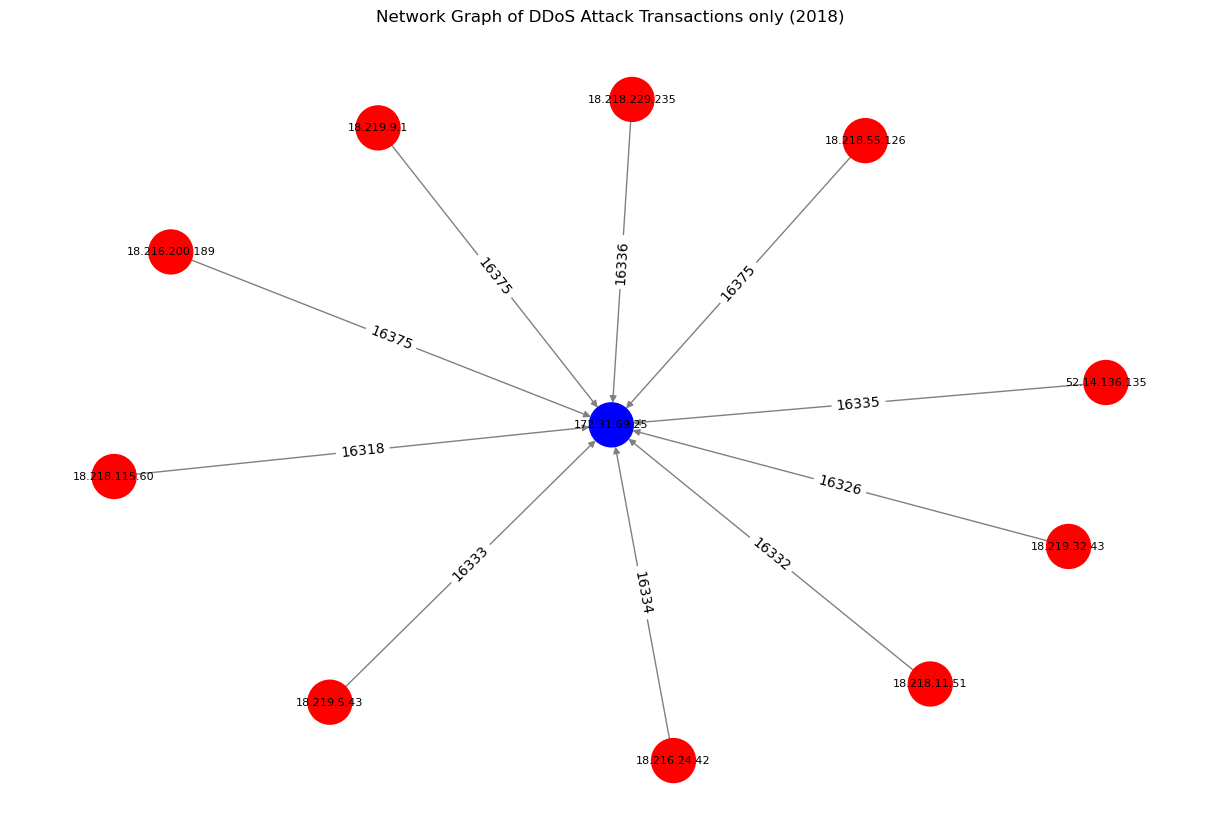

In [27]:
analysis_df = ddos2018_df_cleaned.copy()

# Filter rows where attack happened (between 10:00 and 12:00) and Label is 'DDoS attacks-LOIC-HTTP'
analysis_df_filtered = analysis_df[
    (analysis_df['Label'] == 'DDoS attacks-LOIC-HTTP')
]
analysis_df_filtered = analysis_df_filtered[['Source IP', 'Destination IP', 'Flow ID']]
# Create a network graph
G = nx.DiGraph()

# Add edges with weight as the number of unique flow IDs
for _, row in analysis_df_filtered.iterrows():
    src, dst, flow_id = row['Source IP'], row['Destination IP'], row['Flow ID']
    if G.has_edge(src, dst):
        G[src][dst]['weight'].add(flow_id)
    else:
        G.add_edge(src, dst, weight={flow_id})

# Convert the 'weight' set to its length for final visualization
for u, v, data in G.edges(data=True):
    data['weight'] = len(data['weight'])  # Set weight to the number of unique flow IDs

# Get unique nodes
src_ips = set(analysis_df_filtered['Source IP'])
dst_ips = set(analysis_df_filtered['Destination IP'])

# Assign colors (e.g., red for sources, blue for destinations)
node_colors = ['red' if node in src_ips else 'blue' for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.kamada_kawai_layout(G)  # Positioning for better visualization

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, edge_color="gray", font_size=8, arrows=True)

# Draw edge weights (unique flow IDs)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Display the network graph
plt.title("Network Graph of DDoS Attack Transactions only (2018)")
plt.show()

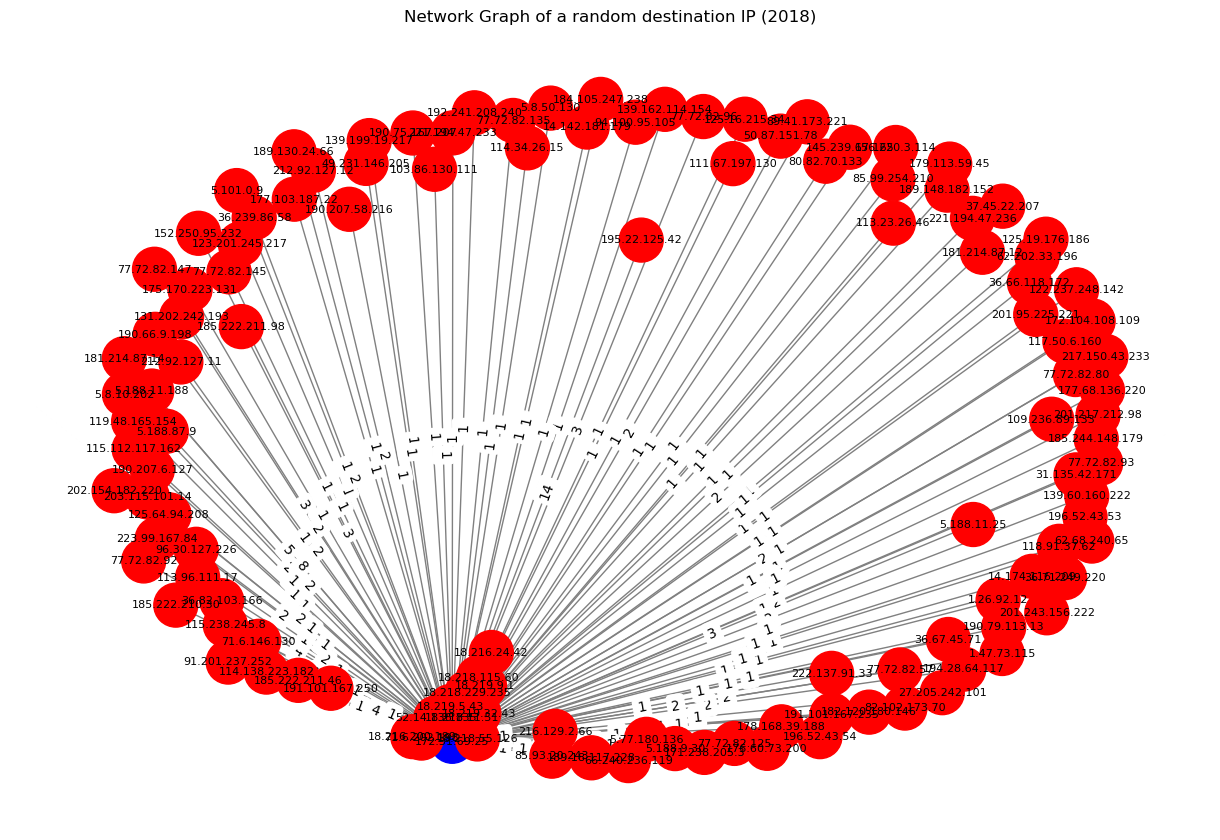

In [ ]:
analysis_df = ddos2018_df_cleaned.copy()

# Filter rows to a random benign Destination IP
analysis_df_filtered = analysis_df[
    (analysis_df['Destination IP'] == '172.31.69.25')
]
analysis_df_filtered = analysis_df_filtered[['Source IP', 'Destination IP', 'Flow ID']]
G = nx.DiGraph()

# Add edges with weight as the number of unique flow IDs
for _, row in analysis_df_filtered.iterrows():
    src, dst, flow_id = row['Source IP'], row['Destination IP'], row['Flow ID']
    if G.has_edge(src, dst):
        G[src][dst]['weight'].add(flow_id)
    else:
        G.add_edge(src, dst, weight={flow_id})

# Convert the 'weight' set to its length for final visualization
for u, v, data in G.edges(data=True):
    data['weight'] = len(data['weight'])  # Set weight to the number of unique flow IDs

# Get unique nodes
src_ips = set(analysis_df_filtered['Source IP'])
dst_ips = set(analysis_df_filtered['Destination IP'])

# Assign colors (e.g., red for sources, blue for destinations)
node_colors = ['red' if node in src_ips else 'blue' for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=3, scale=6)  # Positioning for better visualization

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, edge_color="gray", font_size=8, arrows=True)

# Draw edge weights (unique flow IDs)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Display the network graph
plt.title("Network Graph of a random destination IP (2018)")
plt.show()

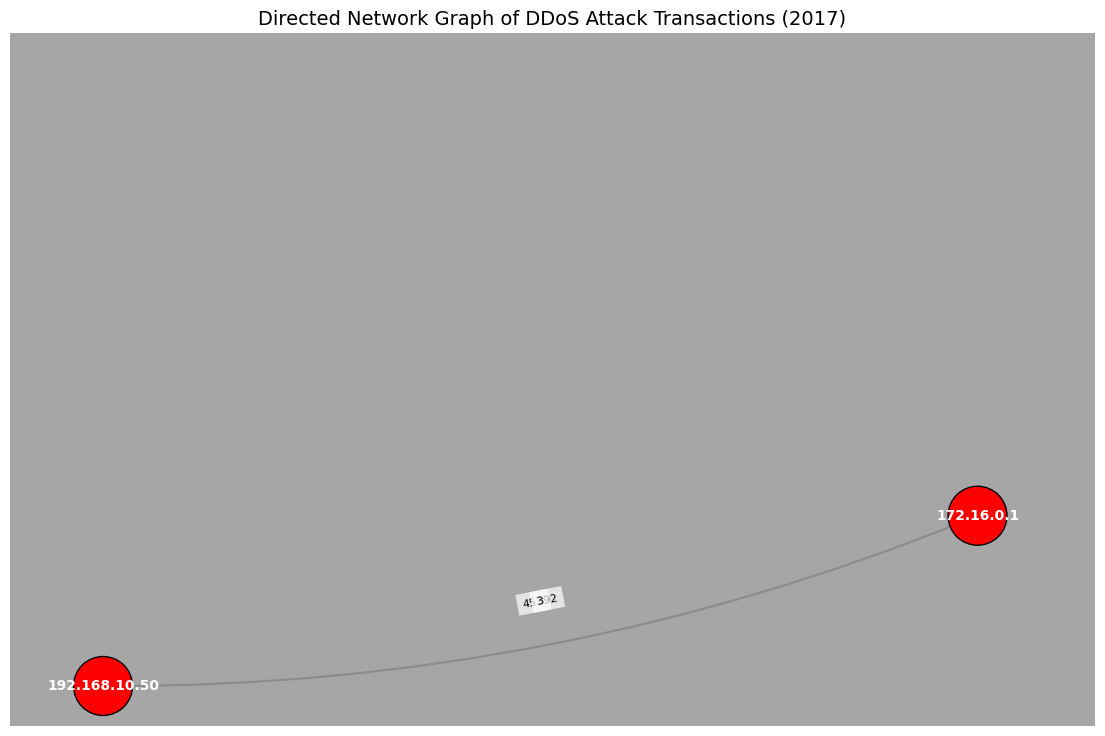

In [65]:

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

analysis_df = ddos2017_df_cleaned.copy()

# Filter rows to a random benign Destination IP
analysis_df_filtered = analysis_df[
    (analysis_df['Label'] == 'DDoS')
]
analysis_df_filtered = analysis_df_filtered[['Source IP', 'Destination IP', 'Flow ID']]

# Create a directed graph
G = nx.DiGraph()

# Add edges with weight as the number of unique flow IDs
for _, row in analysis_df_filtered.iterrows():
    src, dst, flow_id = row['Source IP'], row['Destination IP'], row['Flow ID']
    if G.has_edge(src, dst):
        G[src][dst]['weight'].add(flow_id)
    else:
        G.add_edge(src, dst, weight={flow_id})

# Convert 'weight' set to its length (number of unique flow IDs)
for u, v, data in G.edges(data=True):
    data['weight'] = len(data['weight'])

# Get unique nodes
src_ips = set(analysis_df_filtered['Source IP'])
dst_ips = set(analysis_df_filtered['Destination IP'])

# Assign colors (Red for sources, Blue for destinations)
node_colors = ['red' if node in src_ips else 'blue' for node in G.nodes()]

# Adjust layout to space out nodes
pos = nx.spring_layout(G, k=2, iterations=100, scale=5)  # Higher k spreads nodes apart

plt.figure(figsize=(14, 9), facecolor="white")

# Draw nodes with black edges
nx.draw_networkx_nodes(G, pos, node_size=1800, node_color=node_colors, edgecolors='black')

# Draw directed edges with visible arrows
edge_weights = [G[u][v]['weight'] / 2 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.7, width=edge_weights,
                       arrowstyle='-|>', arrows=True, arrowsize=15, connectionstyle="arc3,rad=0.1")

# Draw node labels (White for better contrast)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold", font_color="white")

# Draw edge labels (weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color="black",
                             bbox=dict(facecolor="white", edgecolor="none", alpha=0.7))

plt.title("Directed Network Graph of DDoS Attack Transactions (2017)", fontsize=14)
plt.axis("off")  # Hide axes
plt.show()


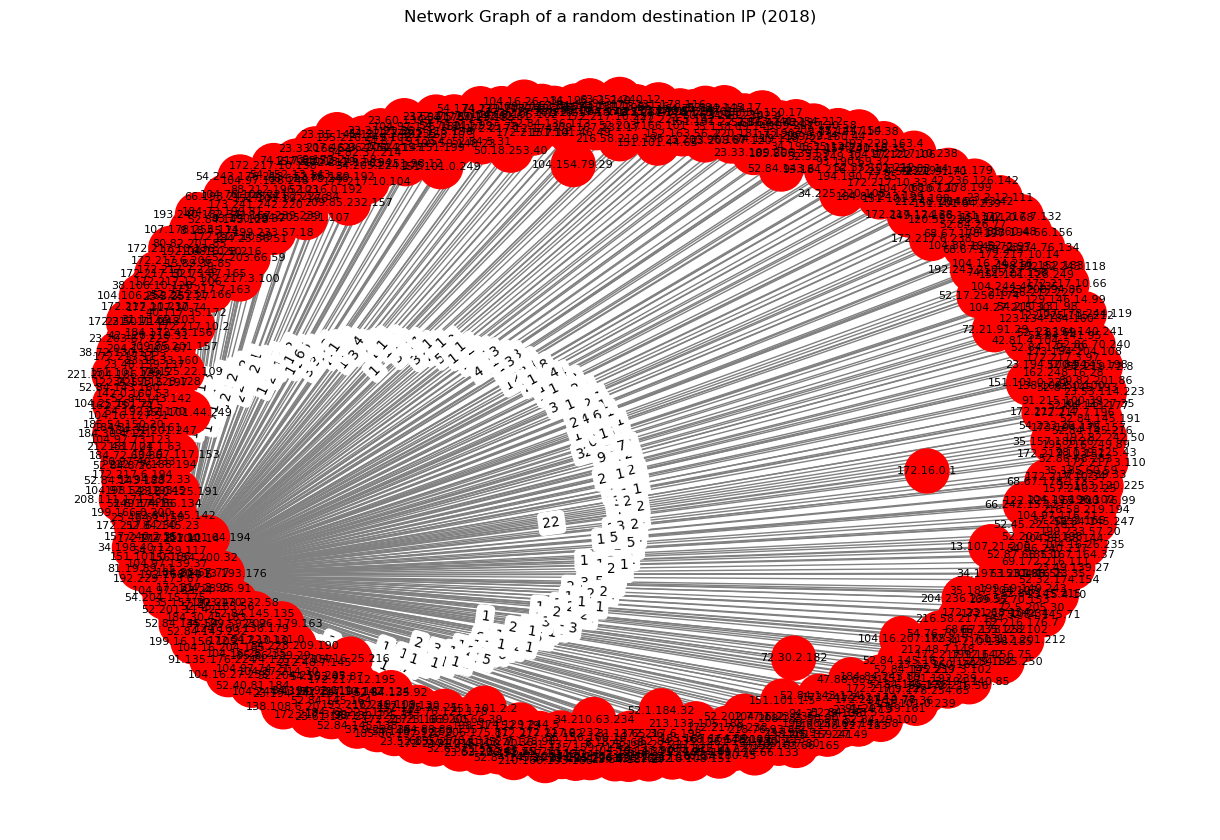

In [ ]:
analysis_df = ddos2017_df_cleaned.copy()

# Filter rows to a random benign Destination IP
analysis_df_filtered = analysis_df[
    (analysis_df['Destination IP'] == '192.168.10.5')
]
analysis_df_filtered = analysis_df_filtered[['Source IP', 'Destination IP', 'Flow ID']]
G = nx.DiGraph()

# Add edges with weight as the number of unique flow IDs
for _, row in analysis_df_filtered.iterrows():
    src, dst, flow_id = row['Source IP'], row['Destination IP'], row['Flow ID']
    if G.has_edge(src, dst):
        G[src][dst]['weight'].add(flow_id)
    else:
        G.add_edge(src, dst, weight={flow_id})

# Convert the 'weight' set to its length for final visualization
for u, v, data in G.edges(data=True):
    data['weight'] = len(data['weight'])  # Set weight to the number of unique flow IDs

# Get unique nodes
src_ips = set(analysis_df_filtered['Source IP'])
dst_ips = set(analysis_df_filtered['Destination IP'])

# Assign colors (e.g., red for sources, blue for destinations)
node_colors = ['red' if node in src_ips else 'blue' for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=3, scale=6)  # Positioning for better visualization

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, edge_color="gray", font_size=8, arrows=True)

# Draw edge weights (unique flow IDs)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Display the network graph
plt.title("Network Graph of a random destination IP (2017)")
plt.show()

### Different Graph structure

In [46]:
# Initialize the graph
# edges to be put between flows that have the same source and destination IPs. 
# if a flow is classified attack at least once, the flow is considered an attack node. 

G = nx.Graph()

# Assuming `network_df` is your DataFrame with Flow ID, Source IP, Destination IP, and Label
for _, row in network_df.iterrows():
    flow_id, src_ip, dst_ip, label = row["Flow ID"], row["Source IP"], row["Destination IP"], row["Label"]
    
    # Add the flow node (if it doesn't exist yet)
    if not G.has_node(flow_id):
        G.add_node(flow_id, label=label, source_ip=src_ip, destination_ip=dst_ip)
    
    # Add edges between flows that share the same source and destination IP
    for neighbor_flow_id in G.nodes:
        if G.nodes[neighbor_flow_id]["source_ip"] == src_ip and G.nodes[neighbor_flow_id]["destination_ip"] == dst_ip:
            G.add_edge(flow_id, neighbor_flow_id)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/emmalim/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/kf/13qk055j6hz1vpgtkkpw6pyw0000gn/T/ipykernel_19577/3783149657.py", line -1, in <module>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/emmalim/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/emmalim/anaconda3/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/emmalim/anaconda3/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1326, in structured_trace

## Initial feature engineering

In [101]:
df2 = ddos2018_df_cleaned.copy()

# Convert to dtypes
df2['Label'] = df2['Label'].astype('category')
df2['Destination Port'] = df2['Destination Port'].astype('category')
df2['Protocol'] = df2['Protocol'].astype('category')
df2['Timestamp'] = pd.to_datetime(df2['Timestamp'], errors='coerce')

# Remove Ininformative features: 
uninformative_features = [
    'Bwd Avg Bulk Rate', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',  
    'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Fwd Avg Bytes/Bulk',  
    'CWE Flag Count', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Timestamp', 'hour', 'minute'
]
df2.drop(columns=uninformative_features, inplace=True, errors='ignore')

In [102]:
# Select only numerical columns
numerical_cols = df2.select_dtypes(include=['number']).columns
print(len(numerical_cols))

67


## Label Wise Distribution Analysis and Correlation Matrix analysis 
- many features have similar distribution and high correlation. 
- there are many features that have very big separation (eg. ddos attack only have 1 value but the benign have normal dist) 
    - need to check for data leakage for each of these features, if no data leakage this probably indicates that the dataset is highly predictable.

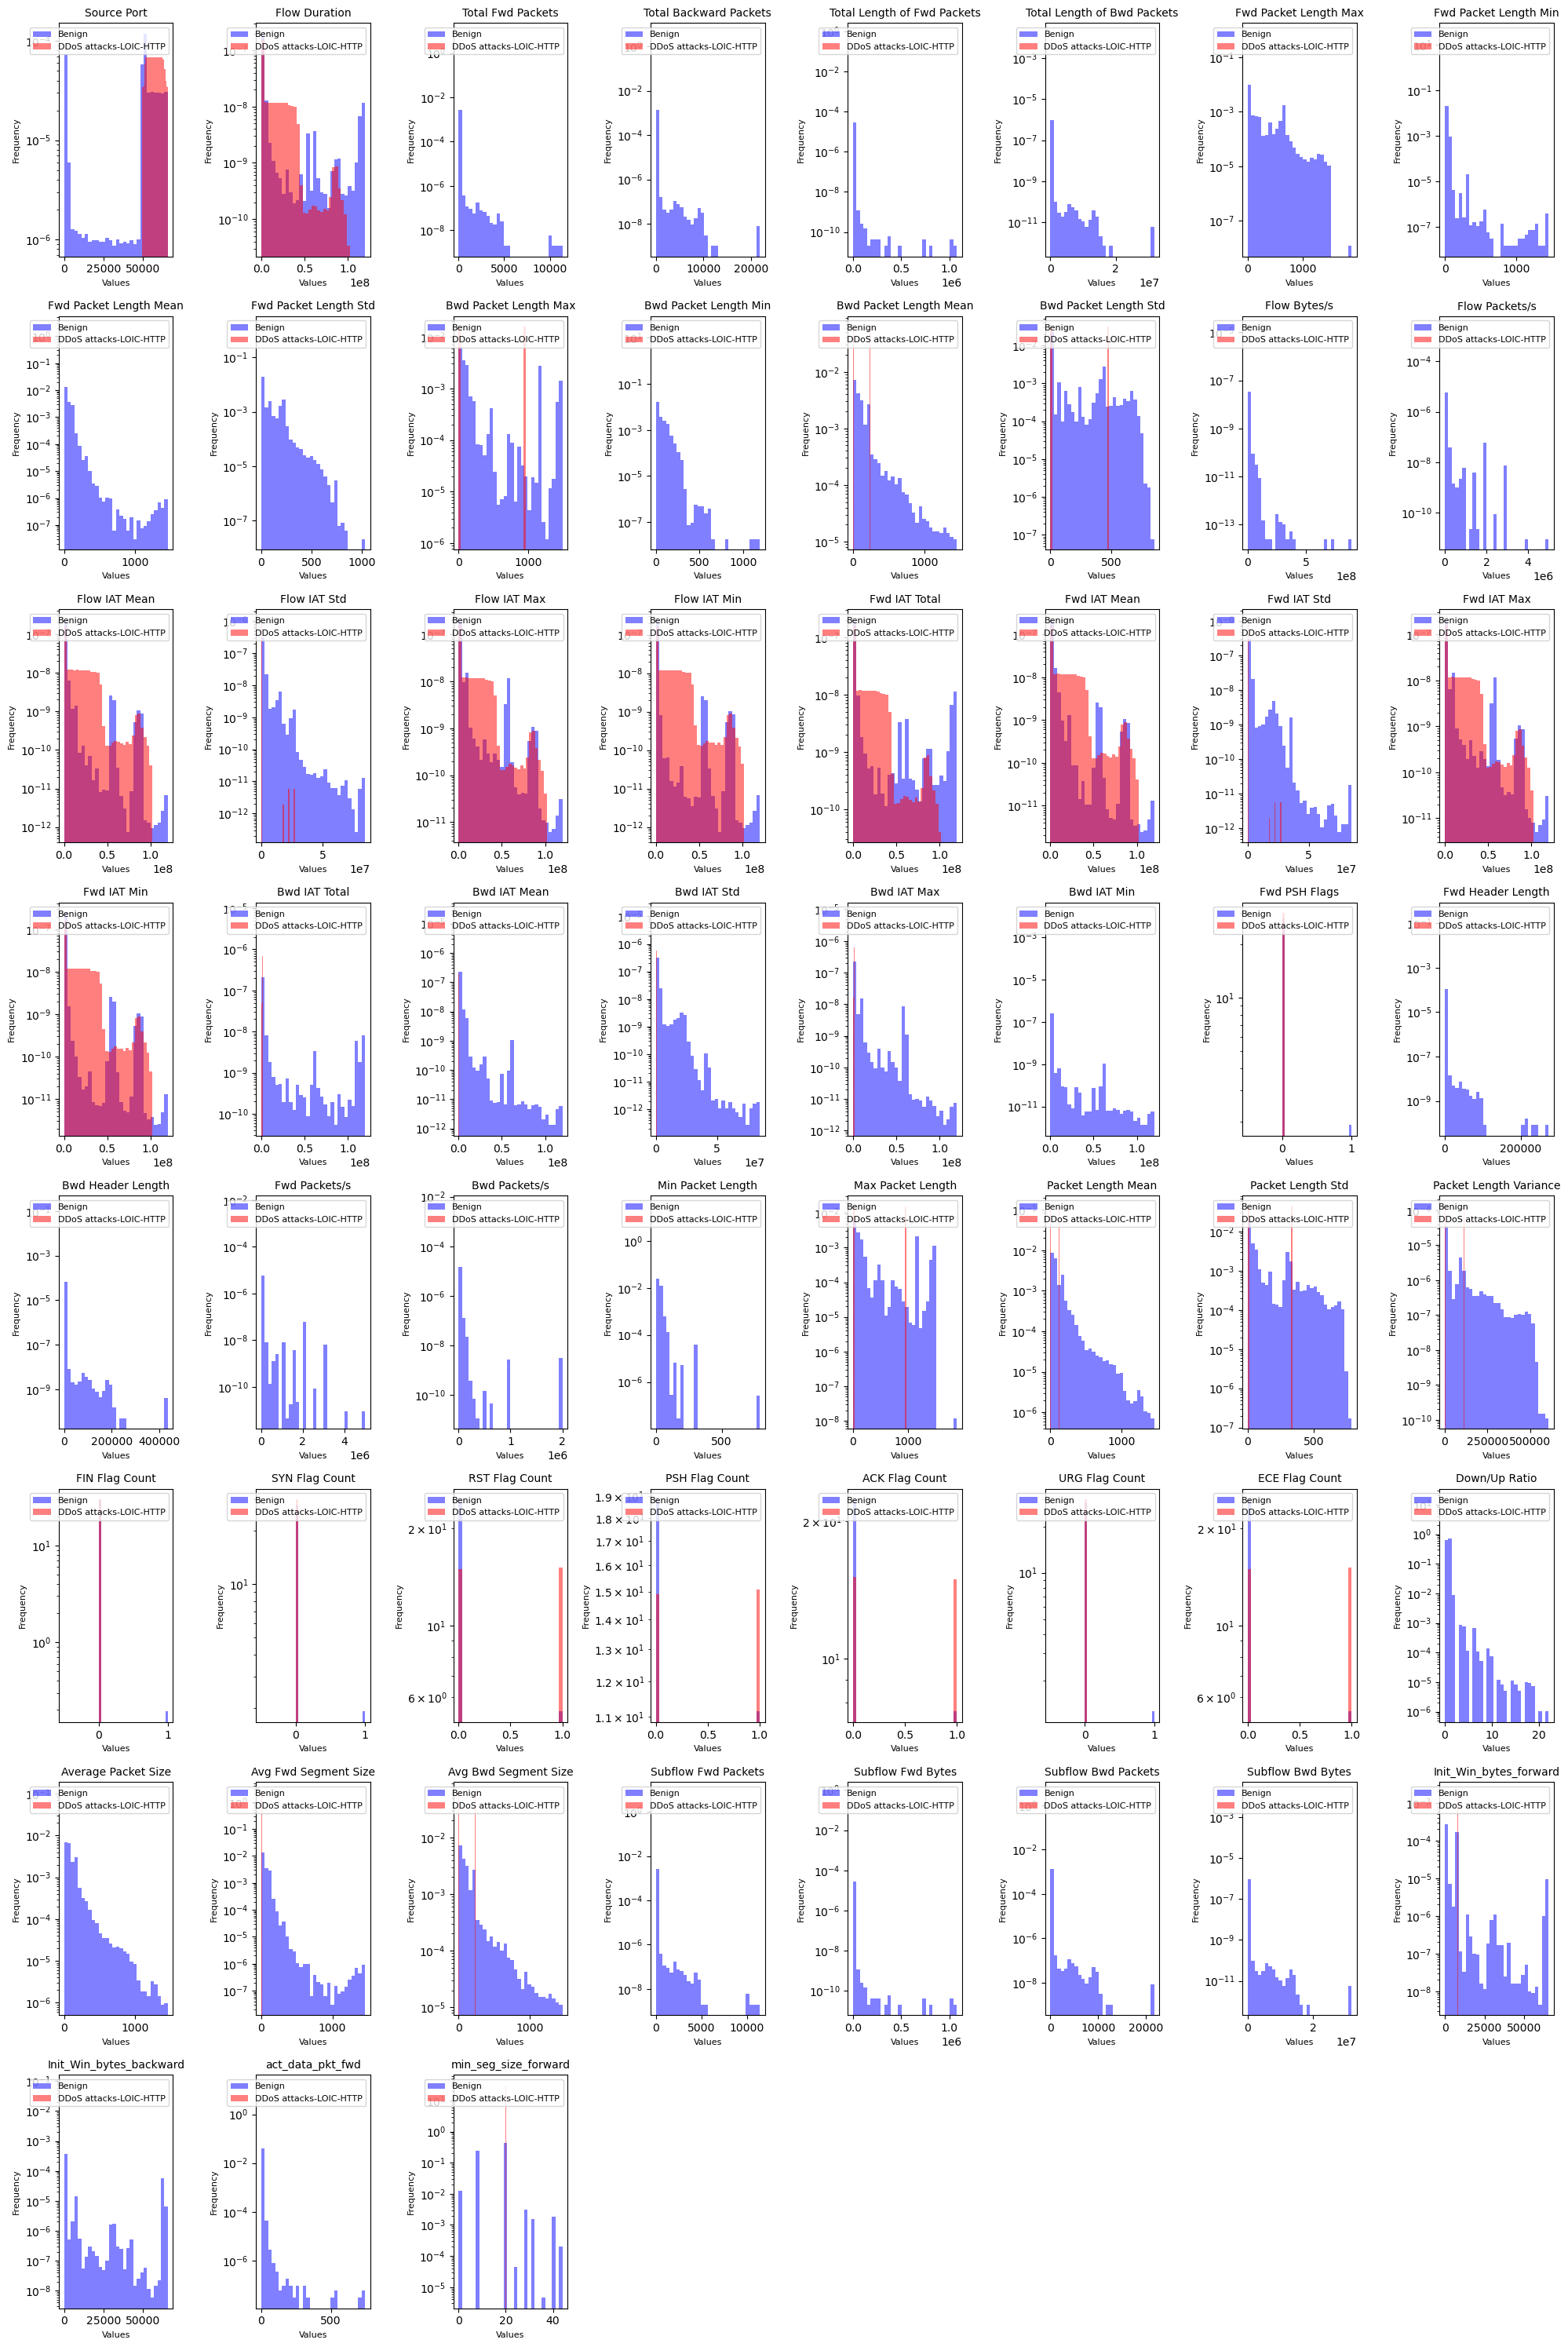

In [80]:
# Define color mapping
label_colors = {'Benign': 'blue', 'DDoS attacks-LOIC-HTTP': 'red'}

# Set figure size
plt.figure(figsize=(20, 30))  # Adjusted for better spacing

# Loop through each numerical column and plot its histogram
rows, cols = 8, 8  # 11 rows × 7 columns = 77 plots
for i, column in enumerate(numerical_cols[:59]):  
    plt.subplot(rows, cols, i + 1)  

    for label, color in label_colors.items():
        subset = df2[df2['Label'] == label][column]
        
        # Remove NaN and infinite values
        subset = subset.replace([np.inf, -np.inf], np.nan).dropna()

        if not subset.empty:
            plt.hist(subset, bins=30, label=label, alpha=0.5, color=color, density=True)
    
    plt.title(column, fontsize=10)
    plt.xlabel('Values', fontsize=8)
    plt.ylabel('Frequency', fontsize=8)
    plt.yscale("log")  # Log scale for better separation
    plt.legend(fontsize=8)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


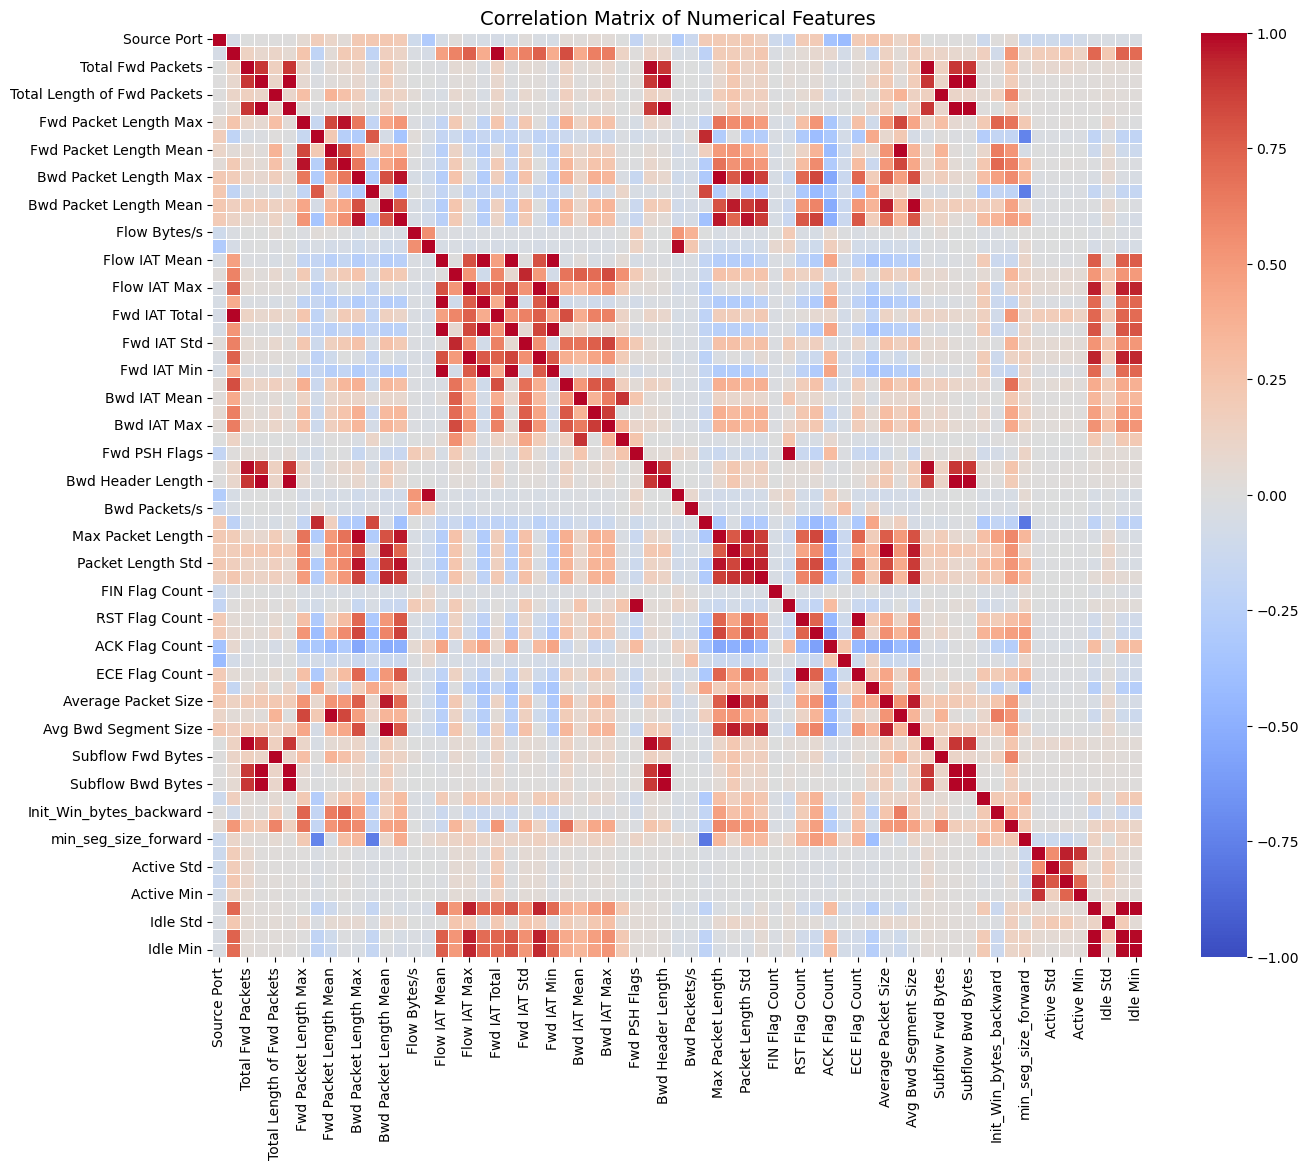

In [81]:
# Select only numerical columns
numerical_cols = df2.select_dtypes(include=['number'])
# Compute correlation matrix
corr_matrix = numerical_cols.corr()

# Set figure size
plt.figure(figsize=(15, 12))

# Create heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

# Title
plt.title("Correlation Matrix of Numerical Features", fontsize=14)

# Show plot
plt.show()


## Baseline RF Model 

In [103]:
additional_uninformative_features = [
    'Total Length of Fwd Packets', 'Fwd Header Length', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 
    'act_data_pkt_fwd', 'Total Length of Bwd Packets', 'Bwd Header Length', 'Subflow Bwd Packets', 
    'Subflow Bwd Bytes', 'Fwd Packets/s', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Min',
    'Idle Min', 'Idle Max', 'Min Packet Length', 'Fwd Seg Size Min', 'Fwd Packet Length Std',
    'Fwd IAT Total', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Avg Fwd Segment Size', 
    'Idle Mean', 'Average Packet Size', 'Avg Bwd Segment Size', 'Active Max', 'Active Min', 
    'Fwd IAT Max', 'SYN Flag Count', 'ECE Flag Count','FIN Flag Count', 'Fwd PSH Flags', 'Active Std', 'Bwd Packet Length Max'
]


# Drop the columns
df2.drop(columns=additional_uninformative_features, inplace=True, errors='ignore')

# Drop unique identifier columns from the dataframe
df2 = df2.drop(columns=['Flow ID', 'Source IP', 'Destination IP', 'Destination Port', 'Protocol', 'Source Port'])

# Verify the remaining columns
print(df2.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918684 entries, 0 to 1918683
Data columns (total 33 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   Flow Duration            int64   
 1   Total Fwd Packets        int64   
 2   Total Backward Packets   int64   
 3   Fwd Packet Length Max    float64 
 4   Fwd Packet Length Min    float64 
 5   Fwd Packet Length Mean   float64 
 6   Bwd Packet Length Min    float64 
 7   Bwd Packet Length Mean   float64 
 8   Bwd Packet Length Std    float64 
 9   Flow Bytes/s             float64 
 10  Flow Packets/s           float64 
 11  Flow IAT Mean            float64 
 12  Flow IAT Std             float64 
 13  Flow IAT Max             float64 
 14  Fwd IAT Std              float64 
 15  Bwd IAT Total            float64 
 16  Bwd IAT Mean             float64 
 17  Bwd IAT Std              float64 
 18  Bwd IAT Max              float64 
 19  Bwd IAT Min              float64 
 20  Bwd Packets/s           

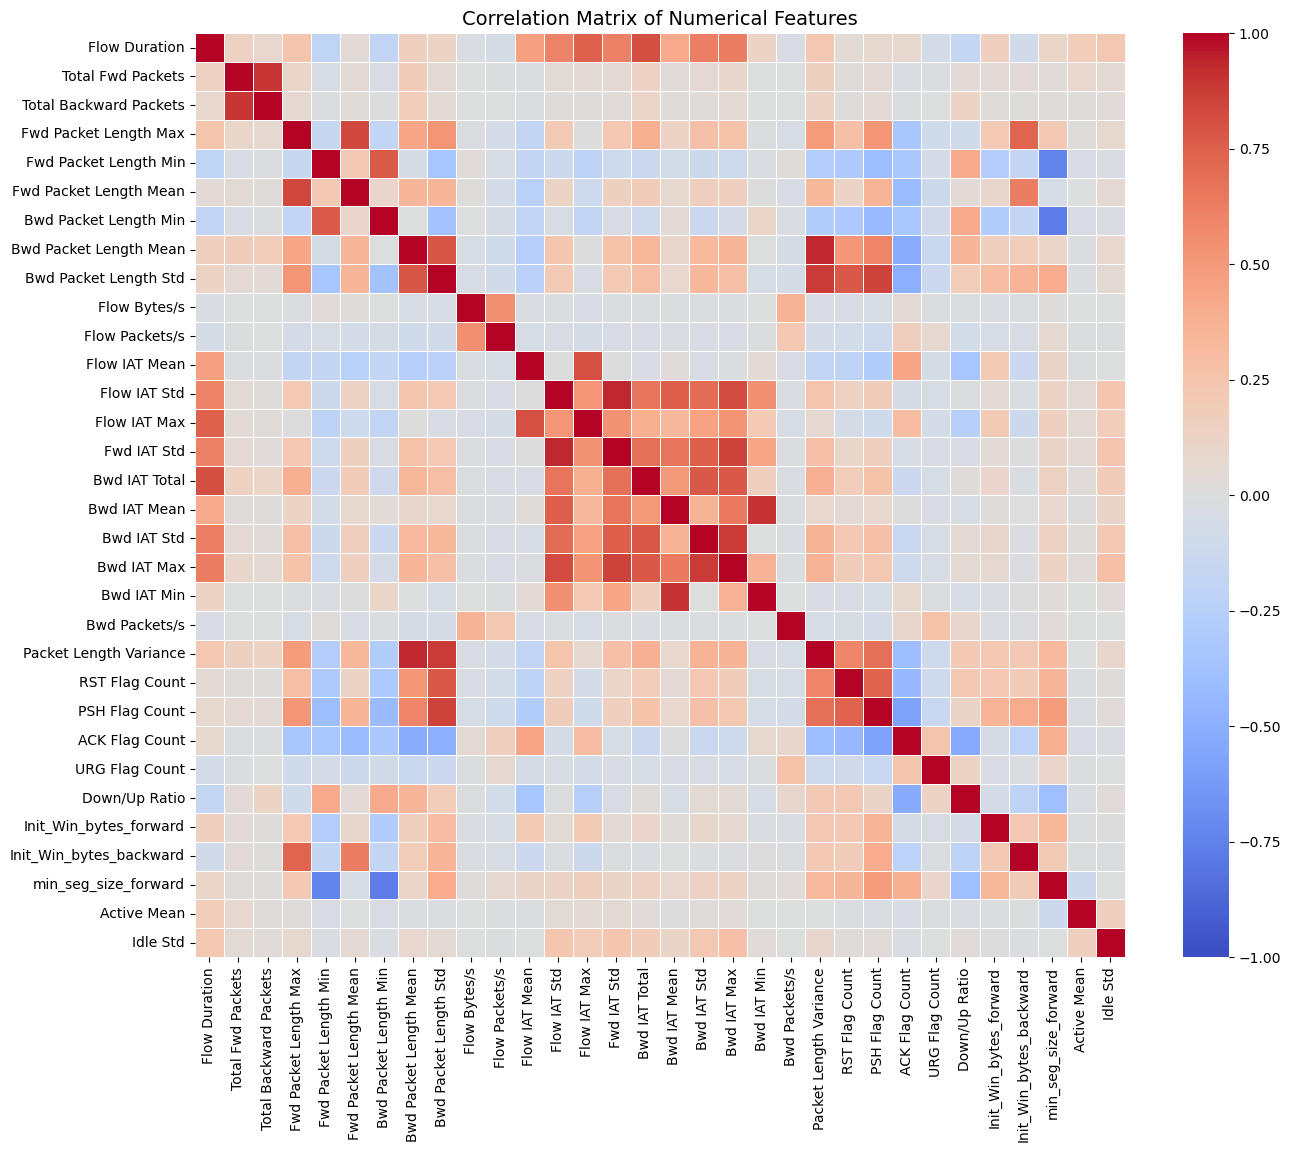

In [104]:
# Select only numerical columns
numerical_cols = df2.select_dtypes(include=['number'])
# Compute correlation matrix
corr_matrix = numerical_cols.corr()

# Set figure size
plt.figure(figsize=(15, 12))

# Create heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

# Title
plt.title("Correlation Matrix of Numerical Features", fontsize=14)

# Show plot
plt.show()

In [105]:
# Count the number of NaN values in each column
# fill Flowbytes NaN values with 0 --> 

nan_counts = df2.isna().sum()
df2["Flow Bytes/s"].fillna(0, inplace=True)
print(nan_counts)

Flow Duration                 0
Total Fwd Packets             0
Total Backward Packets        0
Fwd Packet Length Max         0
Fwd Packet Length Min         0
Fwd Packet Length Mean        0
Bwd Packet Length Min         0
Bwd Packet Length Mean        0
Bwd Packet Length Std         0
Flow Bytes/s               6831
Flow Packets/s                0
Flow IAT Mean                 0
Flow IAT Std                  0
Flow IAT Max                  0
Fwd IAT Std                   0
Bwd IAT Total                 0
Bwd IAT Mean                  0
Bwd IAT Std                   0
Bwd IAT Max                   0
Bwd IAT Min                   0
Bwd Packets/s                 0
Packet Length Variance        0
RST Flag Count                0
PSH Flag Count                0
ACK Flag Count                0
URG Flag Count                0
Down/Up Ratio                 0
Init_Win_bytes_forward        0
Init_Win_bytes_backward       0
min_seg_size_forward          0
Active Mean                   0
Idle Std

/var/folders/kf/13qk055j6hz1vpgtkkpw6pyw0000gn/T/ipykernel_11616/2260900423.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["Flow Bytes/s"].fillna(0, inplace=True)


In [106]:
# Random Forest Prediction - Baseline Model
df_model = df2.copy()

# Separate the target variable (Label) and the features
X = df_model.drop(columns=['Label'])  # Drop the target variable from the features
y = df_model['Label']

# Convert categorical variables to numeric using pd.get_dummies or LabelEncoder
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding the categorical variables
X.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
X.fillna(0, inplace=True)  # Fill NaN with 0

# Encode the 'Label' column (target variable) into numeric values: 0 for 'Benign' and 1 for 'DDoS attacks-LOIC-HTTP'
y = y.map({'Benign': 0, 'DDoS attacks-LOIC-HTTP': 1})

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Optional: Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    268658
           1       1.00      1.00      1.00    115079

    accuracy                           1.00    383737
   macro avg       1.00      1.00      1.00    383737
weighted avg       1.00      1.00      1.00    383737

Accuracy Score: 0.9999583047764484
Confusion Matrix:
[[268645     13]
 [     3 115076]]


In [108]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print accuracy score
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Optional: Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Additional metrics
precision = precision_score(y_test, y_pred, average='macro')  # or 'micro', 'weighted' as needed
recall = recall_score(y_test, y_pred, average='macro')  # or 'micro', 'weighted' as needed
f1 = f1_score(y_test, y_pred, average='macro')  # or 'micro', 'weighted' as needed

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    268658
           1       1.00      1.00      1.00    115079

    accuracy                           1.00    383737
   macro avg       1.00      1.00      1.00    383737
weighted avg       1.00      1.00      1.00    383737

Accuracy Score: 0.9999583047764484
Confusion Matrix:
[[268645     13]
 [     3 115076]]
Precision: 0.9999379384554663
Recall: 0.9999627711470411
F1 Score: 0.9999503536843326


Feature Importances (sorted from high to low):
Fwd Packet Length Mean: 0.13766837049950292
Fwd Packet Length Max: 0.11368912775251204
Flow IAT Mean: 0.11362978948527269
Flow IAT Max: 0.10593993122084418
Flow Duration: 0.09849734551282491
Fwd IAT Std: 0.0736550319946796
Flow Packets/s: 0.07307167093988852
Init_Win_bytes_forward: 0.06086288853798778
Total Fwd Packets: 0.0460369402645217
Flow Bytes/s: 0.0211862743269117
Total Backward Packets: 0.020917227629013328
Flow IAT Std: 0.0209153015056111
Packet Length Variance: 0.01594247639896212
Bwd IAT Mean: 0.011991275487080096
Bwd Packet Length Std: 0.01109530459892031
Bwd IAT Total: 0.01048275430920954
Bwd Packets/s: 0.010455611596036142
Init_Win_bytes_backward: 0.009306188772849406
min_seg_size_forward: 0.0073096801006741555
Bwd IAT Std: 0.006578408523517883
ACK Flag Count: 0.006029014496475194
Bwd IAT Min: 0.005915313923481004
Bwd Packet Length Mean: 0.004708338956670019
Bwd IAT Max: 0.004558930938653663
Idle Std: 0.002825897121086497
Act

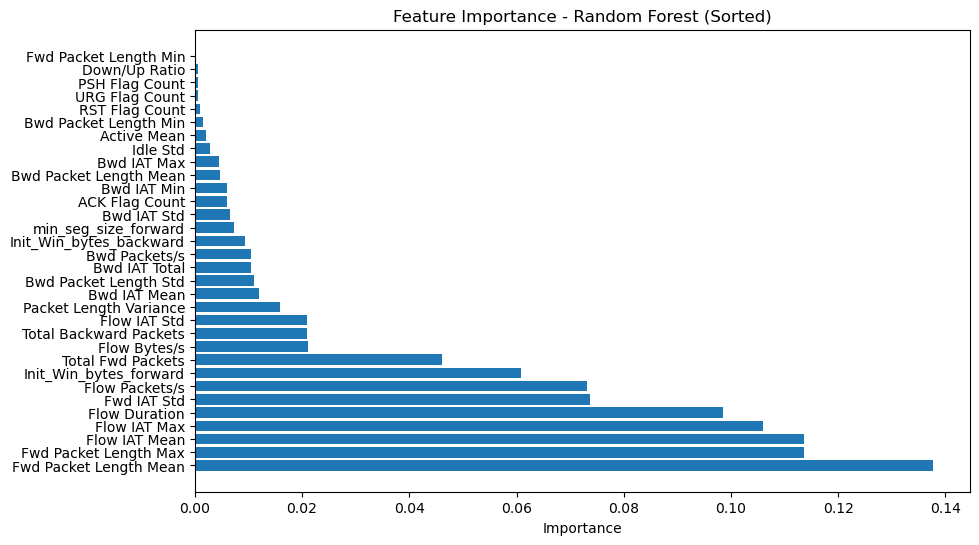

In [109]:
# Get feature importances from the RandomForest model
feature_importances = rf_model.feature_importances_

# Create a list of feature names and their corresponding importances
feature_importance_dict = zip(X.columns, feature_importances)  # Use X.columns to keep the column names intact

# Sort the features by importance (high to low)
sorted_features = sorted(feature_importance_dict, key=lambda x: x[1], reverse=True)

# Display sorted feature importances
print("Feature Importances (sorted from high to low):")
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

# Separate the sorted features and importances for plotting
sorted_feature_names = [x[0] for x in sorted_features]
sorted_importances = [x[1] for x in sorted_features]

# Plot the sorted feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest (Sorted)')
plt.show()


# Train on entire 2018 and test on entire 2017 / other way 

In [72]:
ddos2018_df_cleaned = pd.read_csv('/Users/emmalim/Desktop/DSA4263/ddos2018_cleaned.csv')
ddos2017_df_cleaned = pd.read_csv('/Users/emmalim/Desktop/DSA4263/ddos2017_cleaned.csv')
ddos2017_df_cleaned['Label'] = ddos2017_df_cleaned['Label'].map({'BENIGN': 0, 'DDoS': 1})
ddos2018_df_cleaned['Label'] = ddos2018_df_cleaned['Label'].map({'Benign': 0, 'DDoS attacks-LOIC-HTTP': 1})
print(ddos2017_df_cleaned['Label'].value_counts())
print(ddos2018_df_cleaned['Label'].value_counts())

Label
1    128027
0     97718
Name: count, dtype: int64
Label
0    1343290
1     575394
Name: count, dtype: int64


In [73]:
# Remove Unimporant features from both dataset

# features_to_remove = [
#     'Bwd Avg Bulk Rate', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',  
#     'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Fwd Avg Bytes/Bulk',  
#     'CWE Flag Count', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Timestamp', 'hour', 'minute',
#     'Total Length of Fwd Packets', 'Fwd Header Length', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 
#     'act_data_pkt_fwd', 'Total Length of Bwd Packets', 'Bwd Header Length', 'Subflow Bwd Packets', 
#     'Subflow Bwd Bytes', 'Fwd Packets/s', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Min',
#     'Idle Min', 'Idle Max', 'Min Packet Length', 'Fwd Seg Size Min', 'Fwd Packet Length Std',
#     'Fwd IAT Total', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Avg Fwd Segment Size', 
#     'Idle Mean', 'Average Packet Size', 'Avg Bwd Segment Size', 'Active Max', 'Active Min', 
#     'Fwd IAT Max', 'SYN Flag Count', 'ECE Flag Count','FIN Flag Count', 'Fwd PSH Flags', 'Active Std', 'Bwd Packet Length Max',
#     'Flow ID', 'Source IP', 'Destination IP', 'Destination Port', 'Protocol', 'Source Port'
# ]

features_to_remove = [
    'Flow ID', 'Source IP', 'Destination IP', 'Destination Port', 'Protocol', 'Source Port', 'Timestamp', 'hour', 'minute',
]

ddos2018_df_cleaned.drop(columns=features_to_remove, inplace=True, errors='ignore')
ddos2017_df_cleaned.drop(columns=features_to_remove, inplace=True, errors='ignore')

ddos2018_df_cleaned["Flow Bytes/s"].fillna(0, inplace=True)
ddos2017_df_cleaned["Flow Bytes/s"].fillna(0, inplace=True)

large_value = 1e10
ddos2018_df_cleaned['Flow Bytes/s'] = ddos2018_df_cleaned['Flow Bytes/s'].replace([np.inf, -np.inf], large_value)
ddos2017_df_cleaned['Flow Bytes/s'] = ddos2017_df_cleaned['Flow Bytes/s'].replace([np.inf, -np.inf], large_value)
ddos2018_df_cleaned['Flow Packets/s'] = ddos2018_df_cleaned['Flow Packets/s'].replace([np.inf, -np.inf], large_value)
ddos2017_df_cleaned['Flow Packets/s'] = ddos2017_df_cleaned['Flow Packets/s'].replace([np.inf, -np.inf], large_value)


print(ddos2018_df_cleaned.info())
print(ddos2017_df_cleaned.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918684 entries, 0 to 1918683
Data columns (total 77 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Flow Duration                int64  
 1   Total Fwd Packets            int64  
 2   Total Backward Packets       int64  
 3   Total Length of Fwd Packets  float64
 4   Total Length of Bwd Packets  float64
 5   Fwd Packet Length Max        float64
 6   Fwd Packet Length Min        float64
 7   Fwd Packet Length Mean       float64
 8   Fwd Packet Length Std        float64
 9   Bwd Packet Length Max        float64
 10  Bwd Packet Length Min        float64
 11  Bwd Packet Length Mean       float64
 12  Bwd Packet Length Std        float64
 13  Flow Bytes/s                 float64
 14  Flow Packets/s               float64
 15  Flow IAT Mean                float64
 16  Flow IAT Std                 float64
 17  Flow IAT Max                 float64
 18  Flow IAT Min                 float64
 19  

/var/folders/kf/13qk055j6hz1vpgtkkpw6pyw0000gn/T/ipykernel_27786/3147259239.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ddos2018_df_cleaned["Flow Bytes/s"].fillna(0, inplace=True)
/var/folders/kf/13qk055j6hz1vpgtkkpw6pyw0000gn/T/ipykernel_27786/3147259239.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

In [76]:
# Separate features and target variables
X_train = ddos2017_df_cleaned.drop(columns=['Label'])
y_train = ddos2017_df_cleaned['Label']
X_test = ddos2018_df_cleaned.drop(columns=['Label'])
y_test = ddos2018_df_cleaned['Label']

# Normalize the features
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score,recall_score,f1_score

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', report)

# Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, you can also print Precision, Recall, and F1-Score separately:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.7423
Classification Report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.84   1343290
           1       1.00      0.14      0.25    575394

    accuracy                           0.74   1918684
   macro avg       0.87      0.57      0.55   1918684
weighted avg       0.81      0.74      0.67   1918684

Confusion Matrix:
[[1343290       0]
 [ 494455   80939]]
Precision: 1.0000
Recall: 0.1407
F1 Score: 0.2466


In [84]:
print(y_test.value_counts())

Label
0    1343290
1     575394
Name: count, dtype: int64


In [85]:
# Get feature importances from the trained model
feature_importances = rf_model.feature_importances_

# Print the feature importances
print("Feature Importances:")

# Assuming X_train already contains the features, not the 'Label' column
feature_names = X_train.columns  # Directly use the columns of X_train

# Display the feature importance alongside feature names
for feature, importance in zip(feature_names, feature_importances):
    print(f"{feature}: {importance:.4f}")


Feature Importances:
Flow Duration: 0.0042
Total Fwd Packets: 0.0399
Total Backward Packets: 0.0315
Total Length of Fwd Packets: 0.0521
Total Length of Bwd Packets: 0.0151
Fwd Packet Length Max: 0.0628
Fwd Packet Length Min: 0.0017
Fwd Packet Length Mean: 0.0856
Fwd Packet Length Std: 0.0060
Bwd Packet Length Max: 0.0231
Bwd Packet Length Min: 0.0313
Bwd Packet Length Mean: 0.0266
Bwd Packet Length Std: 0.0200
Flow Bytes/s: 0.0033
Flow Packets/s: 0.0024
Flow IAT Mean: 0.0005
Flow IAT Std: 0.0089
Flow IAT Max: 0.0004
Flow IAT Min: 0.0009
Fwd IAT Total: 0.0325
Fwd IAT Mean: 0.0179
Fwd IAT Std: 0.0197
Fwd IAT Max: 0.0389
Fwd IAT Min: 0.0069
Bwd IAT Total: 0.0016
Bwd IAT Mean: 0.0043
Bwd IAT Std: 0.0015
Bwd IAT Max: 0.0028
Bwd IAT Min: 0.0001
Fwd PSH Flags: 0.0001
Bwd PSH Flags: 0.0000
Fwd URG Flags: 0.0000
Bwd URG Flags: 0.0000
Fwd Header Length: 0.0286
Bwd Header Length: 0.0117
Fwd Packets/s: 0.0038
Bwd Packets/s: 0.0094
Min Packet Length: 0.0019
Max Packet Length: 0.0032
Packet Length M